In [21]:
import torch
import timeit
import numpy as np

def add_noise_points_to_batch_prenorm_optimized(input_image_batch, noise_points=100, time_dimension=100):
    image_batch = input_image_batch.clone()
    B, C, H, W = image_batch.shape

    if noise_points > 0:
        num_pixels = H * W
        for b in range(B):
            selected_coords = torch.randperm(num_pixels)[:noise_points]
            x_coords, y_coords = torch.div(selected_coords, W, rounding_mode='floor'), selected_coords % W
            noise_values = torch.randint(1, time_dimension, (noise_points,), dtype=image_batch.dtype, device=image_batch.device)

            image_batch[b, 0, x_coords, y_coords] = noise_values

    return image_batch


def add_noise_points_to_batch_prenorm_optimized2(input_image_batch, noise_points=100, time_dimension=100):
    image_batch = input_image_batch.clone()
    B, C, H, W = image_batch.shape

    if noise_points > 0:
        num_pixels = H * W
        selected_coords = torch.randperm(num_pixels, device=image_batch.device)[:noise_points]
        x_coords, y_coords = torch.div(selected_coords, W, rounding_mode='floor'), selected_coords % W
        noise_values = torch.randint(1, time_dimension, (B, noise_points), dtype=image_batch.dtype, device=image_batch.device)

        batch_indices = torch.arange(B, device=image_batch.device).view(-1, 1).expand(B, noise_points)
        image_batch[batch_indices, 0, x_coords, y_coords] = noise_values

    return image_batch


def add_noise_points_to_batch_prenorm_original(input_image_batch, noise_points=100, time_dimension=100):
    """
    This function will take a batch of images and add noise_points number of random noise points to each image in the batch. Intended use case is adding noise points to the image before the custom normalisation is applied, the noise points added will be integers between 1 and 'time_dimension' which is the max timestep.

    Args:
        input_image_batch (torch tensor): The input image batch to be degraded. Shape [B, C, H, W]  
        noise_points (int): The number of noise points to add to each image in the batch
        time_dimension (int): The number of time steps in the data set, used to set the upper limit of the noise point values. Default = 100

    Returns:
        image_batch (torch tensor): The degraded image batch. Shape [B, C, H, W]
    """

    image_batch = input_image_batch.clone()
    if noise_points > 0:
        #Find dimensions of input image 
        x_dim = image_batch.shape[2]
        y_dim = image_batch.shape[3]

        #For each image in the batch
        for image in image_batch:

            # Create a list of unique random x and y coordinates
            num_pixels = x_dim * y_dim
            all_coords = np.arange(num_pixels)
            selected_coords = np.random.choice(all_coords, noise_points, replace=False)  ##### NOTE: Change to using a torch random function instead of a numpy one
            x_coords, y_coords = np.unravel_index(selected_coords, (x_dim, y_dim))
            
            # Iterate through noise_points number of random pixels to noise
            for i in range(noise_points):

                # Add a random number between 1 and time dim
                image[0][x_coords[i], y_coords[i]] = np.random.uniform(1, time_dimension)   ##### NOTE: Change to using a torch random function instead of a numpy one

    return image_batch

Original output shape: torch.Size([10, 1, 128, 88])
Optimized output shape: torch.Size([10, 1, 128, 88])
Optimized output shape2: torch.Size([10, 1, 128, 88])
Optimized output shape3: torch.Size([10, 1, 128, 88])


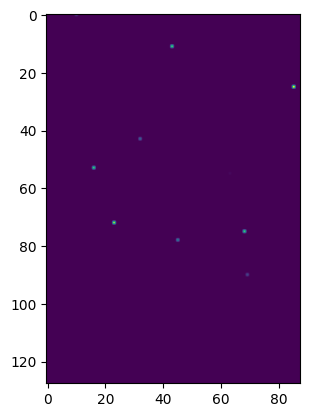

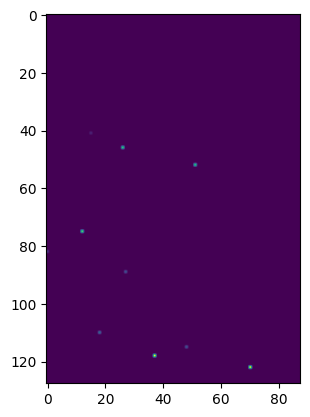

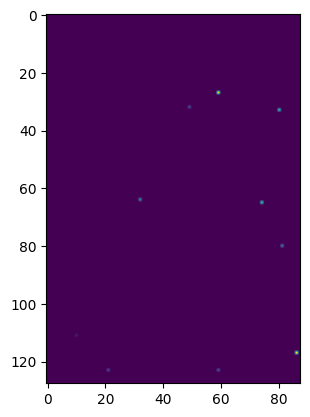

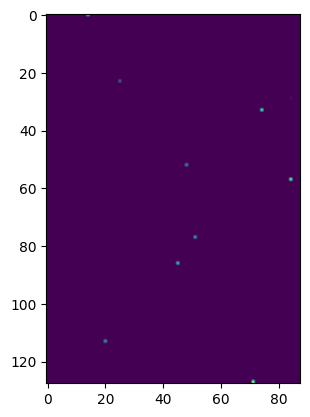

Original method time: 10.176540 seconds
Optimized method time: 3.800015 seconds
Optimized method time2: 0.496901 seconds
Optimized method time3: 0.596369 seconds


In [22]:
import matplotlib.pyplot as plt

# Define input parameters
batch_size = 10
channels = 1
height = 128
width = 88
noise_points = 10
time_dimension = 1000

# Generate a random input batch
input_image_batch = torch.zeros((batch_size, channels, height, width), dtype=torch.float32)

# Run and compare the results of both functions
output_original = add_noise_points_to_batch_prenorm_original(input_image_batch, noise_points, time_dimension)
output_optimized = add_noise_points_to_batch_prenorm_optimized(input_image_batch, noise_points, time_dimension)
output_optimized2 = add_noise_points_to_batch_prenorm_optimized2(input_image_batch, noise_points, time_dimension)
output_optimized3 = add_noise_points_to_batch_prenorm_optimized3(input_image_batch, noise_points, time_dimension)

print(f"Original output shape: {output_original.shape}")
print(f"Optimized output shape: {output_optimized.shape}")
print(f"Optimized output shape2: {output_optimized2.shape}")
print(f"Optimized output shape3: {output_optimized3.shape}")

plt.imshow(output_original[0, 0].cpu().numpy())
plt.show()
plt.imshow(output_optimized[0, 0].cpu().numpy())
plt.show()
plt.imshow(output_optimized2[0, 0].cpu().numpy())
plt.show()
plt.imshow(output_optimized3[0, 0].cpu().numpy())
plt.show()

# Ensure the outputs are the same


# Time both methods using timeit
time_original = timeit.timeit(
    "add_noise_points_to_batch_prenorm_original(input_image_batch, noise_points, time_dimension)",
    globals=globals(),
    number=1000
)

time_optimized = timeit.timeit(
    "add_noise_points_to_batch_prenorm_optimized(input_image_batch, noise_points, time_dimension)",
    globals=globals(),
    number=1000
)

time_optimized2 = timeit.timeit(
    "add_noise_points_to_batch_prenorm_optimized2(input_image_batch, noise_points, time_dimension)",
    globals=globals(),
    number=1000
)

time_optimized3 = timeit.timeit(
    "add_noise_points_to_batch_prenorm_optimized3(input_image_batch, noise_points, time_dimension)",
    globals=globals(),
    number=1000
)


print(f"Original method time: {time_original:.6f} seconds")
print(f"Optimized method time: {time_optimized:.6f} seconds")
print(f"Optimized method time2: {time_optimized2:.6f} seconds")
print(f"Optimized method time3: {time_optimized3:.6f} seconds")


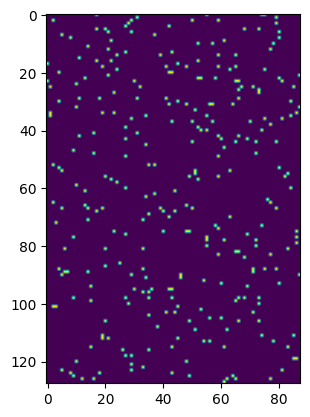

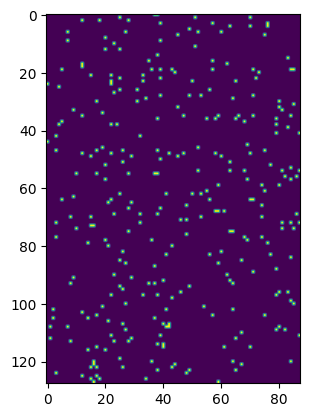

Original output shape: torch.Size([100, 1, 128, 88])
Optimized output shape: torch.Size([100, 1, 128, 88])
The methods return different results.
Original method time: 7.398200 seconds
Optimized method time: 4.736045 seconds


In [58]:
import torch
import timeit

def create_sparse_signal_original(input_image_batch, signal_points=2, linear=False):
    """
    Sets all but 'signal_points' non-zero values to zero in each tensor in the batch.

    Parameters:
    input_image_batch (numpy.ndarray): A 4D array with shape (batch, channel, x, y).
    x (int): The number of non-zero values to leave as they are.

    Returns:
    numpy.ndarray: The modified tensor with sahpe (batch, channel, x, y) with all but 'signal_points' non-zero values set to zero.
    """
    image_batch = input_image_batch.clone()
    flat_batch = image_batch.view(image_batch.size(0), -1)
    nz_counts = torch.sum(flat_batch != 0, dim=1)
    sparse_indices = torch.where(nz_counts > signal_points)[0]

    for idx in sparse_indices:
        nz_indices = torch.nonzero(flat_batch[idx]).squeeze()
        if linear:
            kept_indices = torch.linspace(0, nz_indices.numel() - 1, steps=signal_points).long()
        else:
            kept_indices = torch.randperm(nz_indices.numel())[:signal_points]
        nonkept_indices = nz_indices[~torch.isin(nz_indices, nz_indices[kept_indices])]
        flat_batch[idx, nonkept_indices] = 0

    output_image_batch = flat_batch.view_as(image_batch)
    return output_image_batch

def create_sparse_signal_optimized(image_batch, signal_points=2, linear=False):

    input_image_batch = image_batch.clone()
    flat_batch = input_image_batch.view(input_image_batch.size(0), -1)
    nz_counts = torch.sum(flat_batch != 0, dim=1)
    sparse_indices = torch.where(nz_counts > signal_points)[0]

    for idx in sparse_indices:
        nz_indices = torch.nonzero(flat_batch[idx]).squeeze()
        if linear:
            kept_indices = torch.linspace(0, nz_indices.numel() - 1, steps=signal_points).long()
        else:
            kept_indices = torch.randperm(nz_indices.numel())[:signal_points]

        nonkept_mask = torch.ones(nz_indices.size(0), dtype=torch.bool, device=nz_indices.device)
        nonkept_mask[kept_indices] = False
        nonkept_indices = nz_indices[nonkept_mask]
        flat_batch[idx, nonkept_indices] = 0

    output_image_batch = flat_batch.view_as(input_image_batch)
    return output_image_batch







def verify_results(batch_size=100, channels=1, height=128, width=88, signal_points=300, linear=False):
    input_image_batch = torch.randint(0, 2, (batch_size, channels, height, width)).float()

    original_result = create_sparse_signal_original(input_image_batch, signal_points, linear)
    optimized_result = create_sparse_signal_optimized(input_image_batch, signal_points, linear)

    plt.imshow(original_result[0, 0].cpu().numpy())
    plt.show()
    plt.imshow(optimized_result[0, 0].cpu().numpy())
    plt.show()

    # compare shape fo each tensor
    print(f"Original output shape: {original_result.shape}")
    print(f"Optimized output shape: {optimized_result.shape}")


    if torch.equal((original_result), optimized_result):
        print("Both methods return the same results.")
    else:
        print("The methods return different results.")

def time_methods(batch_size=100, channels=1, height=128, width=88, signal_points=30, linear=False, num_runs=100):
    input_image_batch = torch.randint(0, 2, (batch_size, channels, height, width)).float()

    original_time = timeit.timeit(
        lambda: create_sparse_signal_original(input_image_batch, signal_points, linear),
        number=num_runs
    )

    optimized_time = timeit.timeit(
        lambda: create_sparse_signal_optimized(input_image_batch, signal_points, linear),
        number=num_runs
    )

    print(f"Original method time: {original_time:.6f} seconds")
    print(f"Optimized method time: {optimized_time:.6f} seconds")

# Example usage:
verify_results()
time_methods()


Seed: 821
Original output shape: torch.Size([1000, 1, 88, 128])
Optimized output shape: torch.Size([1000, 1, 88, 128])
Optimized output shape2: torch.Size([1000, 1, 88, 128])
Optimized output shape3: torch.Size([1000, 1, 88, 128])
Optimized output shape4: torch.Size([1000, 1, 88, 128])
Original function time: 9.631573 seconds
Optimized function time: 6.981966 seconds
Optimized function2 time: 6.940957 seconds
Optimized function3 time: 5.131623 seconds
Optimized function4 time: 5.148457 seconds


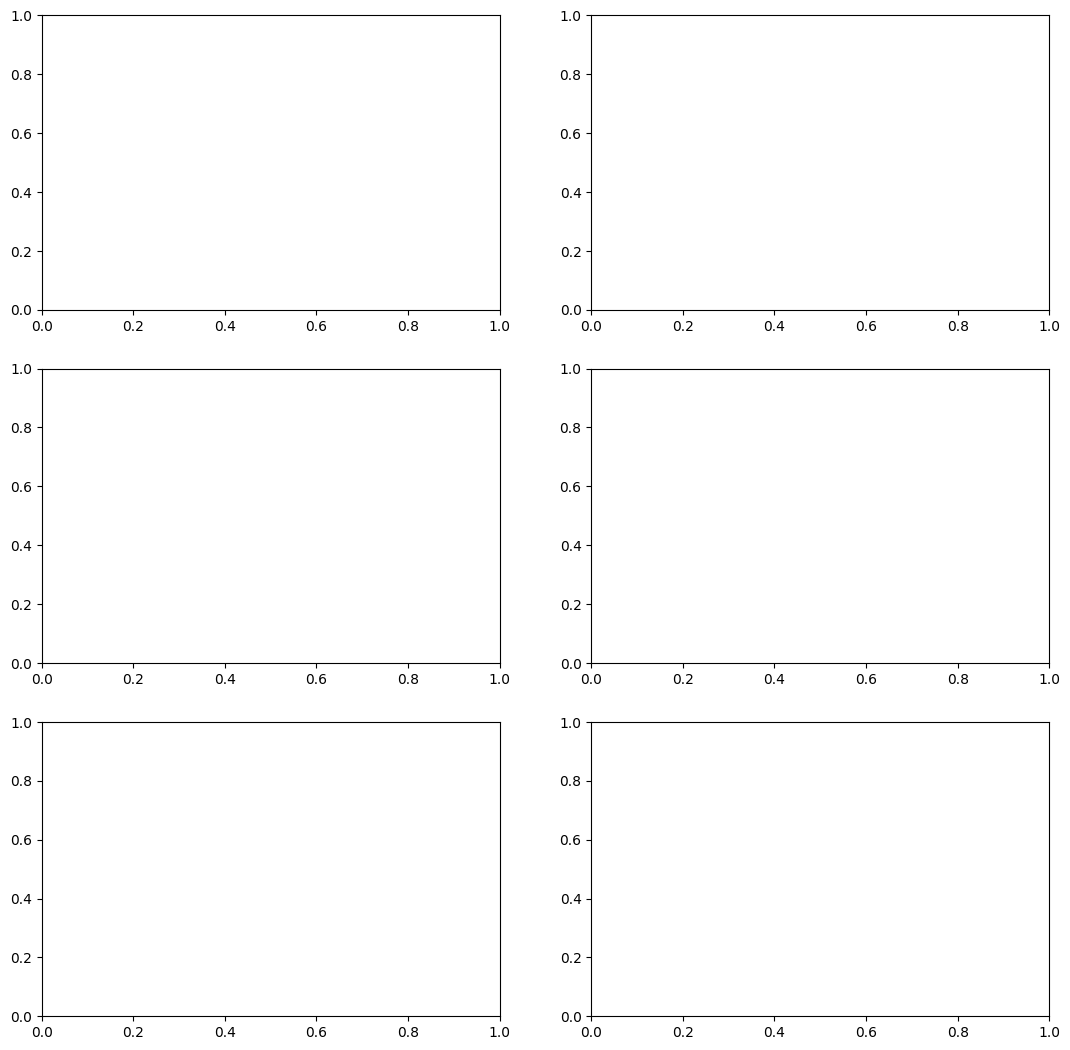

In [283]:
import torch
import timeit
import numpy as np

# Original function
def simulate_detector_resolution_original(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_to_slice):
    dtype = input_image_batch.dtype
    image_batch_all = input_image_batch.clone()
    for idx, image_batch_andc in enumerate(image_batch_all):
        image_batch = image_batch_andc.squeeze()
        x, y = image_batch.size()
        image_batch[image_batch != 0] = image_batch[image_batch != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch[image_batch != 0].shape, device=device, dtype=dtype)
        x_shift = torch.normal(mean=0, std=x_std_dev_pixels, size=(x, y), dtype=dtype, device=device)
        y_shift = torch.normal(mean=0, std=y_std_dev_pixels, size=(x, y), dtype=dtype, device=device)
        mask = image_batch != 0
        new_x_indices = torch.clamp(torch.round(torch.arange(x, device=device).unsqueeze(1) + x_shift), 0, x - 1).long()
        new_y_indices = torch.clamp(torch.round(torch.arange(y, device=device).unsqueeze(0) + y_shift), 0, y - 1).long()
        shifted_image_tensor = torch.zeros_like(image_batch)
        shifted_image_tensor[new_x_indices[mask], new_y_indices[mask]] = image_batch[mask]
        image_batch_all[idx,0] = shifted_image_tensor
    return image_batch_all

# Optimized function
def simulate_detector_resolution_optimized(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_to_slice):
    dtype = input_image_batch.dtype
    image_batch_all = input_image_batch.clone()

    if clamp_photons_to_slice:
        # perform ToF resolution smearing and dont allow photons to move into other slices (unnatural!)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all = torch.clamp(image_batch_all, 0, time_dimension)
    else:
        # perfrom ToF resolution smearing and allow photons to move into other slices (i.e thrown away)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all[image_batch_all > time_dimension] = 0
        image_batch_all[image_batch_all < 1] = 0

    for idx, image_batch_andc in enumerate(image_batch_all):
        image_batch = image_batch_andc.squeeze()
        x, y = image_batch.size()
        x_shift = torch.normal(mean=0, std=x_std_dev_pixels, size=(x, y), dtype=dtype, device=device)
        y_shift = torch.normal(mean=0, std=y_std_dev_pixels, size=(x, y), dtype=dtype, device=device)
        mask = image_batch != 0
        new_x_indices = torch.clamp(torch.round(torch.arange(x, device=device).unsqueeze(1) + x_shift), 0, x - 1).long()
        new_y_indices = torch.clamp(torch.round(torch.arange(y, device=device).unsqueeze(0) + y_shift), 0, y - 1).long()
        shifted_image_tensor = torch.zeros_like(image_batch)
        shifted_image_tensor[new_x_indices[mask], new_y_indices[mask]] = image_batch[mask]
        image_batch_all[idx,0] = shifted_image_tensor
    return image_batch_all
 
def simulate_detector_resolution_optimized2(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_to_slice):
    dtype = input_image_batch.dtype
    image_batch_all = input_image_batch.clone()

    if clamp_photons_to_slice:
        # perform ToF resolution smearing and dont allow photons to move into other slices (unnatural!)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all = torch.clamp(image_batch_all, 0, time_dimension)
    else:
        # perfrom ToF resolution smearing and allow photons to move into other slices (i.e thrown away)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all[image_batch_all > time_dimension] = 0
        image_batch_all[image_batch_all < 1] = 0

    for idx, image_batch_andc in enumerate(image_batch_all):
        image_batch = image_batch_andc.squeeze()
        x, y = image_batch.size()
        
        # Create the shifts
        x_shift = torch.normal(mean=0, std=x_std_dev_pixels, size=(x, y), dtype=dtype, device=device)
        y_shift = torch.normal(mean=0, std=y_std_dev_pixels, size=(x, y), dtype=dtype, device=device)
        
        # Create the mask
        mask = image_batch != 0
        
        # Calculate new indices with shifts
        arange_x = torch.arange(x, device=device).unsqueeze(1)
        arange_y = torch.arange(y, device=device).unsqueeze(0)
        
        new_x_indices = torch.clamp((arange_x + x_shift).round(), 0, x - 1).long()
        new_y_indices = torch.clamp((arange_y + y_shift).round(), 0, y - 1).long()
        
        # Initialize the output tensor
        shifted_image_tensor = torch.zeros_like(image_batch)
        
        # Apply the mask to get the valid indices and values
        valid_x_indices = new_x_indices[mask]
        valid_y_indices = new_y_indices[mask]
        valid_values = image_batch[mask]
        
        # Update the shifted tensor with valid values at the new indices
        shifted_image_tensor[valid_x_indices, valid_y_indices] = valid_values
        
        # Update the original batch
        image_batch_all[idx, 0] = shifted_image_tensor
    return image_batch_all



def simulate_detector_resolution_optimized3(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_to_slice=True):
    dtype = input_image_batch.dtype
    image_batch_all = input_image_batch.clone()

    if clamp_photons_to_slice:
        # perform ToF resolution smearing and dont allow photons to move into other slices (unnatural!)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all = torch.clamp(image_batch_all, 0, time_dimension)
    else:
        # perfrom ToF resolution smearing and allow photons to move into other slices (i.e thrown away)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all[image_batch_all > time_dimension] = 0
        image_batch_all[image_batch_all < 1] = 0
        
        
    # Squeeze the batch dimension
    image_batch_all_squeezed = image_batch_all.squeeze(1)
    
    # Get the size of the images
    batch_size, x, y = image_batch_all_squeezed.size()
    
    # Generate random shifts for all points the batch
    x_shift = torch.normal(mean=0, std=x_std_dev_pixels, size=(batch_size, x, y), dtype=dtype, device=device)
    y_shift = torch.normal(mean=0, std=y_std_dev_pixels, size=(batch_size, x, y), dtype=dtype, device=device)
    
    # Generate indices for the entire batch
    x_indices = torch.arange(x, device=device).view(1, x, 1).expand(batch_size, x, y)
    y_indices = torch.arange(y, device=device).view(1, 1, y).expand(batch_size, x, y)
    
    # Create new indices by adding the shifts
    new_x_indices = torch.clamp(torch.round(x_indices + x_shift), 0, x - 1).long()
    new_y_indices = torch.clamp(torch.round(y_indices + y_shift), 0, y - 1).long()
    
    # Create a mask for non-zero values in the batch
    mask = image_batch_all_squeezed != 0
    
    # Initialize the shifted image tensor
    shifted_image_tensor = torch.zeros_like(image_batch_all_squeezed)
    
    # Apply the shifts using advanced indexing
    batch_indices = torch.arange(batch_size, device=device).view(-1, 1, 1).expand(batch_size, x, y)
    shifted_image_tensor[batch_indices[mask], new_x_indices[mask], new_y_indices[mask]] = image_batch_all_squeezed[mask]
    
    # Unsqueeze to add the channel dimension back
    image_batch_all[:, 0, :, :] = shifted_image_tensor
    return image_batch_all

def simulate_detector_resolution_optimized4(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_to_slice):
    dtype = input_image_batch.dtype
    image_batch_all = input_image_batch.clone()

    if clamp_photons_to_slice:
        # perform ToF resolution smearing and dont allow photons to move into other slices (unnatural!)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all = torch.clamp(image_batch_all, 0, time_dimension)
    else:
        # perfrom ToF resolution smearing and allow photons to move into other slices (i.e thrown away)
        image_batch_all[image_batch_all != 0] = image_batch_all[image_batch_all != 0] + torch.normal(mean=0, std=tof_std_dev_pixels, size=image_batch_all[image_batch_all != 0].shape, device=device, dtype=dtype)
        image_batch_all[image_batch_all > time_dimension] = 0
        image_batch_all[image_batch_all < 1] = 0
        

    # Squeeze the batch dimension
    image_batch_all_squeezed = image_batch_all.squeeze(1)

    # Get the size of the images
    batch_size, x, y = image_batch_all_squeezed.size()

    # Generate random shifts for all points in the batch
    x_shift = torch.normal(mean=0, std=x_std_dev_pixels, size=(batch_size, x, y), dtype=dtype, device=device)
    y_shift = torch.normal(mean=0, std=y_std_dev_pixels, size=(batch_size, x, y), dtype=dtype, device=device)

    # Generate indices for the entire batch
    x_indices = torch.arange(x, device=device, dtype=dtype).view(1, x, 1).expand(batch_size, x, y)
    y_indices = torch.arange(y, device=device, dtype=dtype).view(1, 1, y).expand(batch_size, x, y)

    # Create new indices by adding the shifts
    new_x_indices = torch.clamp(torch.round(x_indices + x_shift), 0, x - 1).long()
    new_y_indices = torch.clamp(torch.round(y_indices + y_shift), 0, y - 1).long()

    # Create a mask for non-zero values in the batch
    mask = image_batch_all_squeezed != 0

    # Initialize the shifted image tensor
    shifted_image_tensor = torch.zeros_like(image_batch_all_squeezed)

    # Apply the shifts using advanced indexing
    batch_indices = torch.arange(batch_size, device=device).view(-1, 1, 1).expand(batch_size, x, y)
    shifted_image_tensor[batch_indices[mask], new_x_indices[mask], new_y_indices[mask]] = image_batch_all_squeezed[mask]

    # Unsqueeze to add the channel dimension back
    image_batch_all[:, 0, :, :] = shifted_image_tensor
    return image_batch_all

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
time_dimension = 1000
clamp_photons_TOF_to_slice = True
batch_size, channels, height, width = 1000, 1, 88, 128
input_image_batch = torch.zeros(batch_size, channels, height, width, device=device)


    
for i in range(30):
    x = np.random.randint(0, height)
    y = np.random.randint(0, width)
    input_image_batch[:, 0, x, y] = np.random.randint(1, time_dimension)

SEED = np.random.randint(1000)  #18 #142
print(f"Seed: {SEED}")

x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels = 5, 5 , 10

# Test and time both functions
def test_and_time_functions():

    # Verify equivalence
    torch.manual_seed(SEED)
    output_original = simulate_detector_resolution_original(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice)

    torch.manual_seed(SEED)
    output_optimized = simulate_detector_resolution_optimized(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice)

    torch.manual_seed(SEED)
    output_optimized2 = simulate_detector_resolution_optimized2(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice)

    torch.manual_seed(SEED)
    output_optimized3 = simulate_detector_resolution_optimized3(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice)

    torch.manual_seed(SEED)
    output_optimized4 = simulate_detector_resolution_optimized4(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice)

    fig, axes = plt.subplots(3, 2, figsize=(13, 13))

    # Define a helper function to display the image with pixel values
    def plot_image_with_values(ax, image, title):
        ax.imshow(image, cmap='viridis')
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                ax.text(j, i, f"{image[i, j]:.2f}", ha="center", va="center", color="black")
        ax.set_title(title)
        fig.colorbar(ax.imshow(image, cmap='viridis'), ax=ax)

    # Plot each image
    #plot_image_with_values(axes[0, 0], input_image_batch[0, 0].cpu().numpy(), 'Input Image')
    #plot_image_with_values(axes[0, 1], output_original[0, 0].cpu().numpy(), 'Output Original')
    #plot_image_with_values(axes[1, 0], output_optimized[0, 0].cpu().numpy(), 'Output Optimized')
    #plot_image_with_values(axes[1, 1], output_optimized2[0, 0].cpu().numpy(), 'Output Optimized 2')
    #plot_image_with_values(axes[2, 0], output_optimized3[0, 0].cpu().numpy(), 'Output Optimized 3')
    #plot_image_with_values(axes[2, 1], output_optimized4[0, 0].cpu().numpy(), 'Output Optimized 4')
    #plt.tight_layout()
    #plt.show()

    print(f"Original output shape: {output_original.shape}")
    print(f"Optimized output shape: {output_optimized.shape}")
    print(f"Optimized output shape2: {output_optimized2.shape}")
    print(f"Optimized output shape3: {output_optimized3.shape}")
    print(f"Optimized output shape4: {output_optimized4.shape}")



    # allclose all the outputs
    #assert torch.allclose(output_original, output_optimized)
    #assert torch.allclose(output_original, output_optimized2)
    #assert torch.allclose(output_original, output_optimized3)
    #assert torch.allclose(output_original, output_optimized4)

    # Time the original function
    original_time = timeit.timeit(
        lambda: simulate_detector_resolution_original(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice),
        number=10
    )
    print(f"Original function time: {original_time:.6f} seconds")

    # Time the optimized function
    optimized_time = timeit.timeit(
        lambda: simulate_detector_resolution_optimized(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice),
        number=10
    )
    print(f"Optimized function time: {optimized_time:.6f} seconds")

    # Time the optimized function2
    optimized_time2 = timeit.timeit(
        lambda: simulate_detector_resolution_optimized2(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice),
        number=10
    )
    print(f"Optimized function2 time: {optimized_time2:.6f} seconds")

    # Time the optimized function3
    optimized_time3 = timeit.timeit(
        lambda: simulate_detector_resolution_optimized3(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice),
        number=10
    )
    print(f"Optimized function3 time: {optimized_time3:.6f} seconds")

    # Time the optimized function4
    optimized_time4 = timeit.timeit(
        lambda: simulate_detector_resolution_optimized4(input_image_batch, x_std_dev_pixels, y_std_dev_pixels, tof_std_dev_pixels, time_dimension, device, clamp_photons_TOF_to_slice),
        number=10
    )
    print(f"Optimized function4 time: {optimized_time4:.6f} seconds")
    


if __name__ == "__main__":
    test_and_time_functions()
